# Import all required libraries

In [ ]:
import pandas as pd
import numpy as np
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.dates import YearLocator, DateFormatter
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Input
from keras.optimizers import Adam

# Read all data into Pandas DataFrames

In [26]:
def process_file(file_path: str, feature_name: str) -> pd.DataFrame:
    """
    Process a single feature file into a DataFrame row with month_year columns.
    
    Args:
        file_path: Path to the CSV file.
        feature_name: Name of the feature (used as the row index).
    
    Returns:
        DataFrame with 1 row and columns like 'jan_1999', 'feb_1999', etc.
    """
    # Define dtype mapping for all monthly columns
    month_columns = ['jan', 'feb', 'mar', 'apr', 'may', 'jun', 
                    'jul', 'aug', 'sep', 'oct', 'nov', 'dec']
    
    dtype_mapping = {col: float for col in month_columns}
    dtype_mapping['Year'] = int  # Keep Year as integer

    # Read CSV with explicit dtype specification
    df = pd.read_csv(file_path, dtype=dtype_mapping)
    
    # Rest of processing remains the same...
    feature_data = pd.DataFrame()
    
    for _, row in df.iterrows():
        year = int(row['Year'])
        monthly_values = row[month_columns]  # Explicit column selection
        
        # Create month_year column names
        month_year_columns = {
            month: f"{month.lower().strip()}_{year}"
            for month in monthly_values.index
        }
        
        year_df = pd.DataFrame([monthly_values.values], 
                              columns=month_year_columns.values())
        feature_data = pd.concat([feature_data, year_df], axis=1)
    
    feature_data.index = [feature_name]
    return feature_data

# List of tuples (file_path, feature_name)
DATA_PATH = '../data/wales/'
feature_files_to_process = [
    (DATA_PATH+'wales_airfrost_days.csv', 'airfrost_days'),
    (DATA_PATH+'wales_precipitation_per_month.csv', 'rainfall'), 
    (DATA_PATH+'wales_monthly_temp.csv', 'temperature'),
    (DATA_PATH+'wales_monthly_sunshine.csv', 'sunshine')
]
crop_production_files_to_process = [
    (DATA_PATH+'wales_oats_production_averaged.csv', 'oats_crop_production'),
    (DATA_PATH+'wales_barley_production_averaged.csv', 'barley_crop_production'),
    (DATA_PATH+'wales_rapeseed_production_averaged.csv', 'rapeseed_crop_production'),
    (DATA_PATH+'wales_wheat_production_averaged.csv', 'wheat_crop_production')
]

# Define variables to store the end result
dataframes = []
all_columns = set()  # Track all possible columns

# Process feature files
for file_path, feature in feature_files_to_process:
    df = process_file(file_path, feature)
    all_columns.update(df.columns)
    dataframes.append(df)


# Now select the crop we need to model
crop_to_model = 'barley_crop_production' # This variable will control which crop we want to process
for file_path, feature in crop_production_files_to_process:
    if feature == crop_to_model:
        df = process_file(file_path, feature)
        all_columns.update(df.columns)
        dataframes.append(df)

final_df = pd.concat(dataframes)
print(final_df)

                        jan_1999  feb_1999  mar_1999  apr_1999  may_1999  \
airfrost_days                6.6       6.1       3.2       4.3       0.0   
rainfall                   250.9     104.0     100.2     122.5      83.4   
temperature                  5.2       4.9       6.4       8.5      11.8   
sunshine                    43.9      53.7      91.9     144.8     131.9   
barley_crop_production   12806.6   12806.6   12806.6   12806.6   12806.6   

                        jun_1999  jul_1999  aug_1999  sep_1999  oct_1999  ...  \
airfrost_days                0.1       0.0       0.0       0.0       0.4  ...   
rainfall                    84.8      28.0     138.0     204.3     137.4  ...   
temperature                 12.5      16.2      15.1      14.0      10.0  ...   
sunshine                   173.3     226.4     144.9     149.1     109.1  ...   
barley_crop_production   12806.6   12806.6   12806.6   12806.6   12806.6  ...   

                        mar_2024  apr_2024  may_2024  ju

# Test for stationarity using ACF method

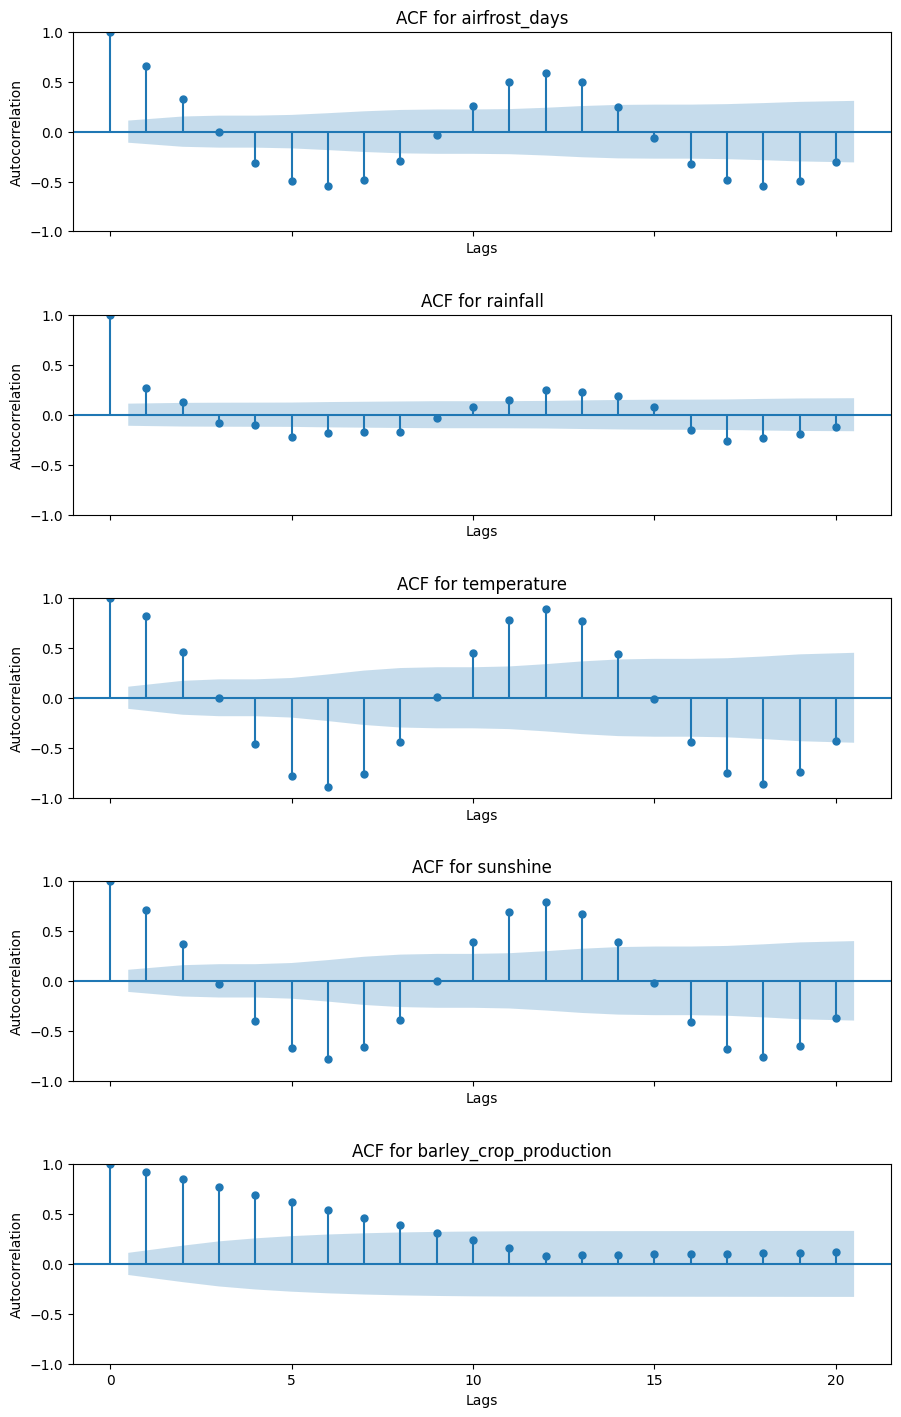

In [27]:
def create_stationarity_plots_using_acf(input_df):
    # Assuming `final_df` is already created and contains the data
    # Transpose the DataFrame to have time as rows and features as columns
    data = input_df.T

    # Plot ACF for each feature
    fig, axes = plt.subplots(len(data.columns), 1, figsize=(10, 15), sharex=True)
    fig.tight_layout(pad=5.0)

    for i, feature in enumerate(data.columns):
        plot_acf(data[feature], ax=axes[i], lags=20)  # Limit lags to 20 for clarity
        axes[i].set_title(f"ACF for {feature}")
        axes[i].set_xlabel("Lags")
        axes[i].set_ylabel("Autocorrelation")

    plt.show()

# Now run the stationarity plots
create_stationarity_plots_using_acf(final_df)

# Plot the input data to visually inspect for trends

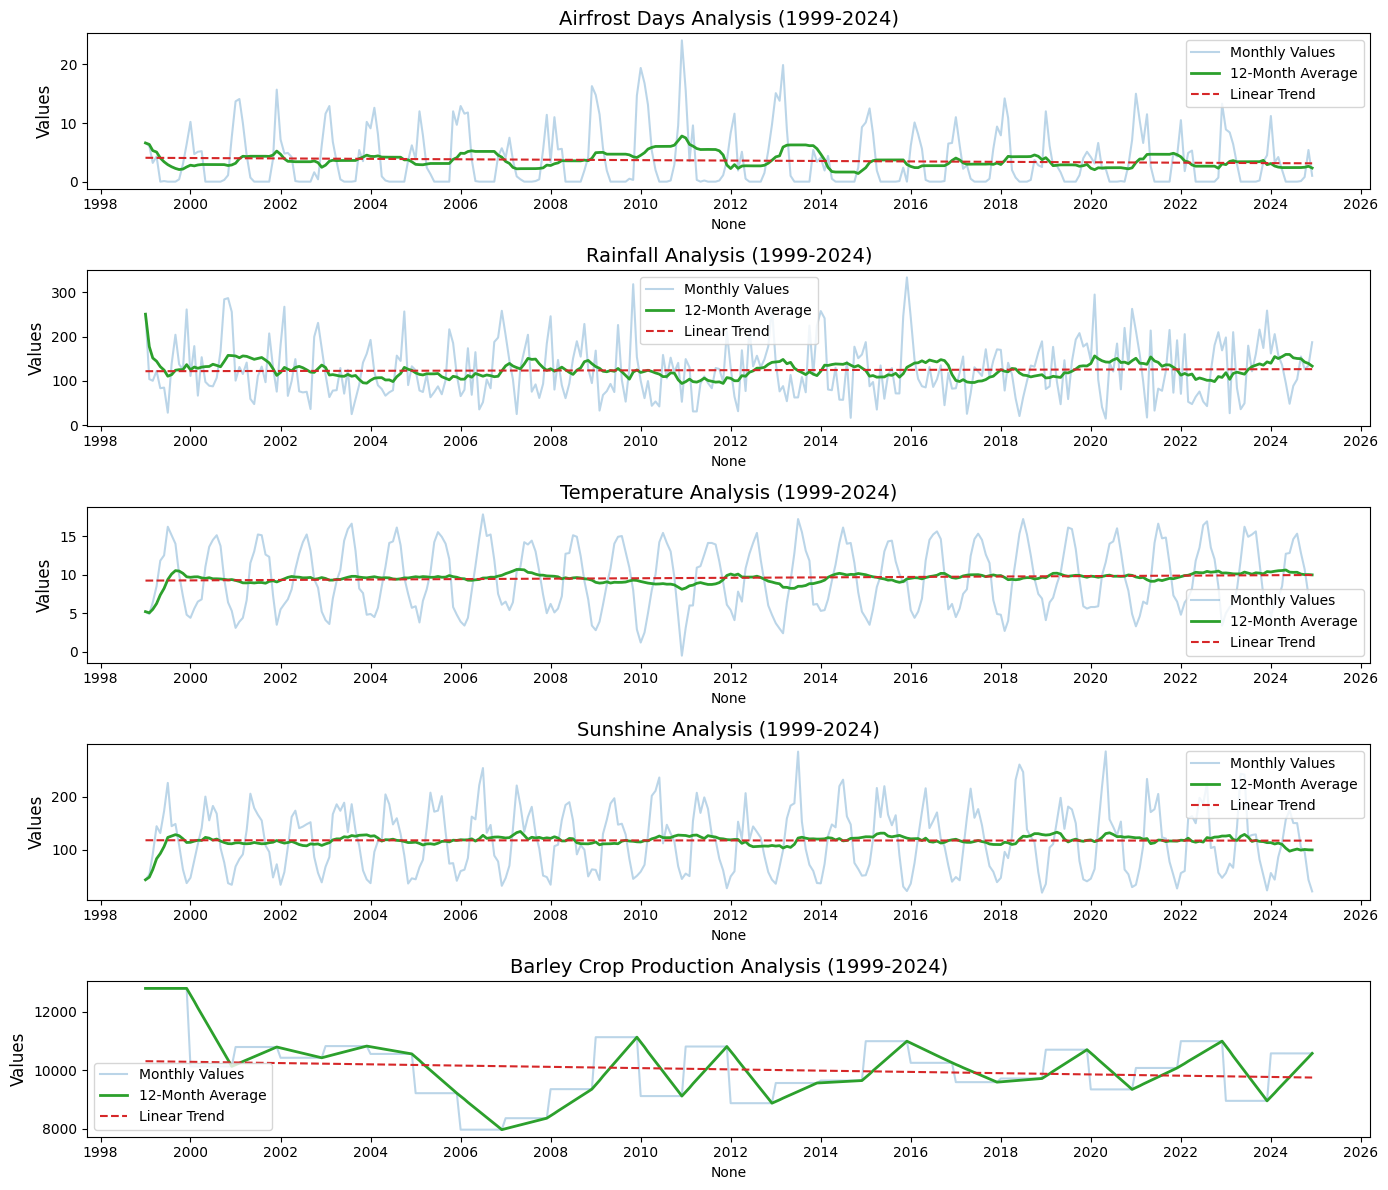

In [28]:
# Create plotting function
def plot_feature_with_analysis(series, feature_name, ax):
    dates = pd.to_datetime(series.index, format='%b_%Y')
    values = series.values.astype(float)
    ts = pd.Series(values, index=dates)
    
    # Calculate components
    rolling_avg = ts.rolling(window=12, min_periods=1).mean()
    ordinal_dates = ts.index.map(pd.Timestamp.toordinal)
    z = np.polyfit(ordinal_dates, values, 1)
    trend_line = np.poly1d(z)(ordinal_dates)

    # Plotting
    sns.lineplot(x=ts.index, y=ts.values, ax=ax, color='#1f77b4', alpha=0.3, label='Monthly Values')
    sns.lineplot(x=rolling_avg.index, y=rolling_avg, ax=ax, color='#2ca02c', linewidth=2, label='12-Month Average')
    sns.lineplot(x=ts.index, y=trend_line, ax=ax, color='#d62728', linestyle='--', label='Linear Trend')
    
    # Formatting
    ax.xaxis.set_major_locator(YearLocator(2))
    ax.xaxis.set_major_formatter(DateFormatter('%Y'))
    ax.set_title(f'{feature_name.replace("_", " ").title()} Analysis (1999-2024)', fontsize=14)
    ax.set_ylabel('Values', fontsize=12)
    ax.legend()

# 3. Generate plots
fig, axes = plt.subplots(5, 1, figsize=(14, 12))
for idx, (feature, data) in enumerate(final_df.iterrows()):
    plot_feature_with_analysis(data, feature, axes[idx])

plt.tight_layout()
plt.show()

# Apply smoothing to the input data

1999-01-01    6.6
1999-02-01    6.1
1999-03-01    3.2
1999-04-01    4.3
1999-05-01    0.0
             ... 
2024-08-01    0.0
2024-09-01    0.1
2024-10-01    0.8
2024-11-01    5.4
2024-12-01    1.0
Length: 312, dtype: float64


/Users/mada/.virtualenvs/mada-proj/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/mada/.virtualenvs/mada-proj/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/mada/.virtualenvs/mada-proj/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/mada/.virtualenvs/mada-proj/lib/python3.10/site-packages/pandas/util/_decorators.py:213: EstimationWarning: Model has no free parameters to estimate. Set optimized=False to suppress this warning
  return func(*args, **kwargs)


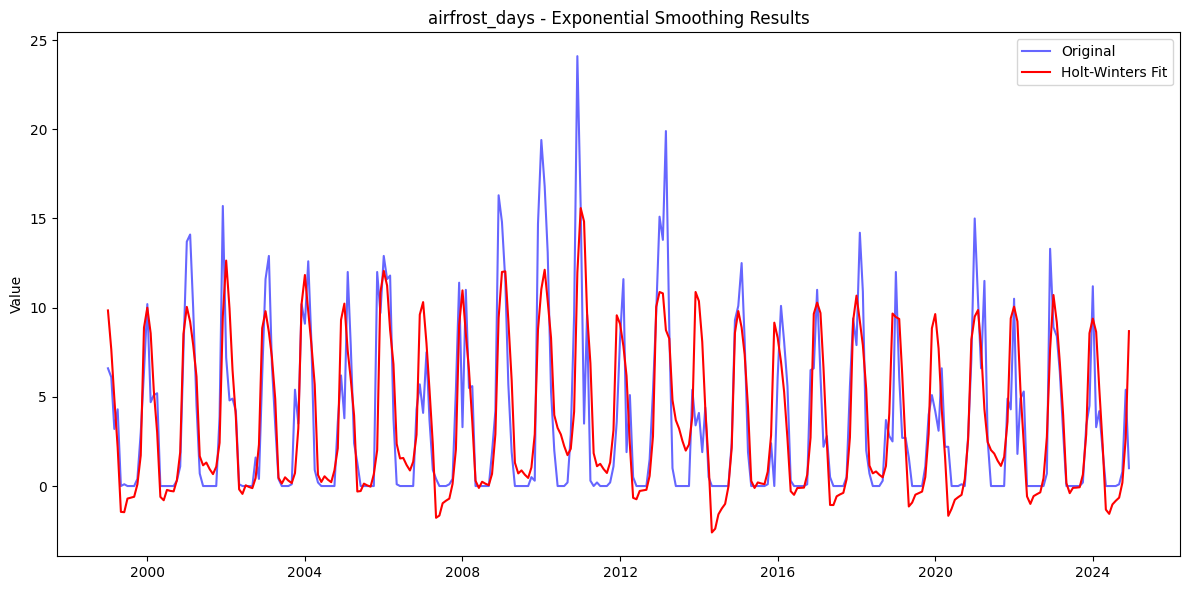


Model Summary for airfrost_days:
                       ExponentialSmoothing Model Results                       
Dep. Variable:                     None   No. Observations:                  312
Model:             ExponentialSmoothing   SSE                           2566.488
Optimized:                        False   AIC                            689.475
Trend:                         Additive   BIC                            749.363
Seasonal:                      Additive   AICC                           691.809
Seasonal Periods:                    12   Date:                 Sat, 10 May 2025
Box-Cox:                          False   Time:                         16:48:04
Box-Cox Coeff.:                    None                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.2073309                alpha             

/Users/mada/.virtualenvs/mada-proj/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/mada/.virtualenvs/mada-proj/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/mada/.virtualenvs/mada-proj/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/mada/.virtualenvs/mada-proj/lib/python3.10/site-packages/pandas/util/_decorators.py:213: EstimationWarning: Model has no free parameters to estimate. Set optimized=False to suppress this warning
  return func(*args, **kwargs)


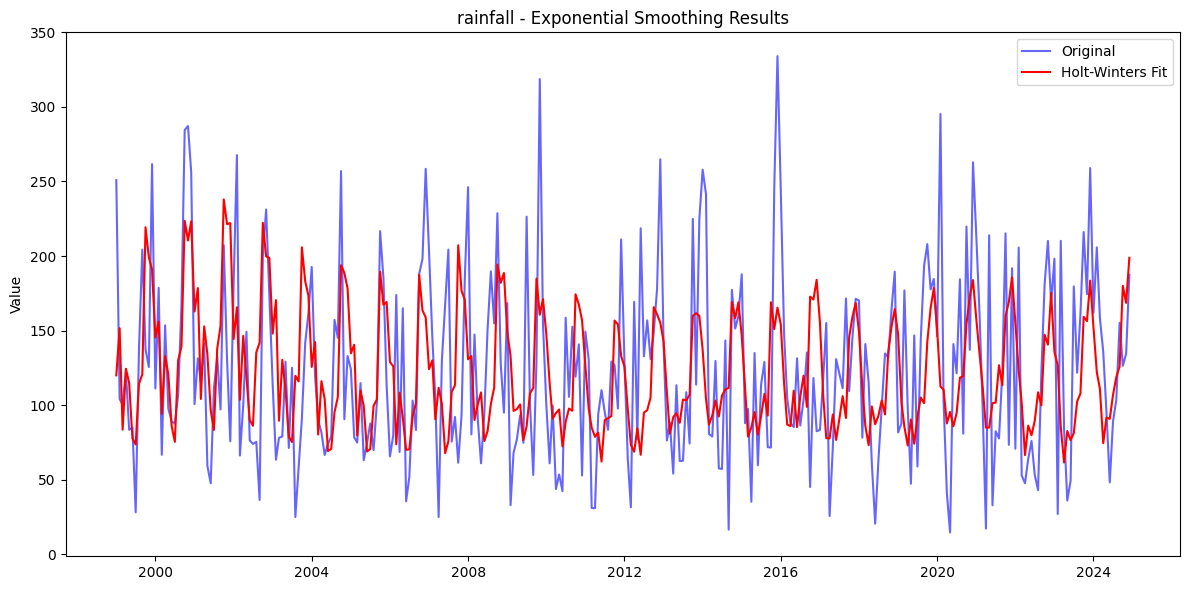

/Users/mada/.virtualenvs/mada-proj/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



Model Summary for rainfall:
                       ExponentialSmoothing Model Results                       
Dep. Variable:                     None   No. Observations:                  312
Model:             ExponentialSmoothing   SSE                        1016589.370
Optimized:                        False   AIC                           2555.756
Trend:                         Additive   BIC                           2615.644
Seasonal:                      Additive   AICC                          2558.090
Seasonal Periods:                    12   Date:                 Sat, 10 May 2025
Box-Cox:                           True   Time:                         16:48:04
Box-Cox Coeff.:                 0.43089                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.0467166                alpha                Fa

/Users/mada/.virtualenvs/mada-proj/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/mada/.virtualenvs/mada-proj/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/mada/.virtualenvs/mada-proj/lib/python3.10/site-packages/pandas/util/_decorators.py:213: EstimationWarning: Model has no free parameters to estimate. Set optimized=False to suppress this warning
  return func(*args, **kwargs)


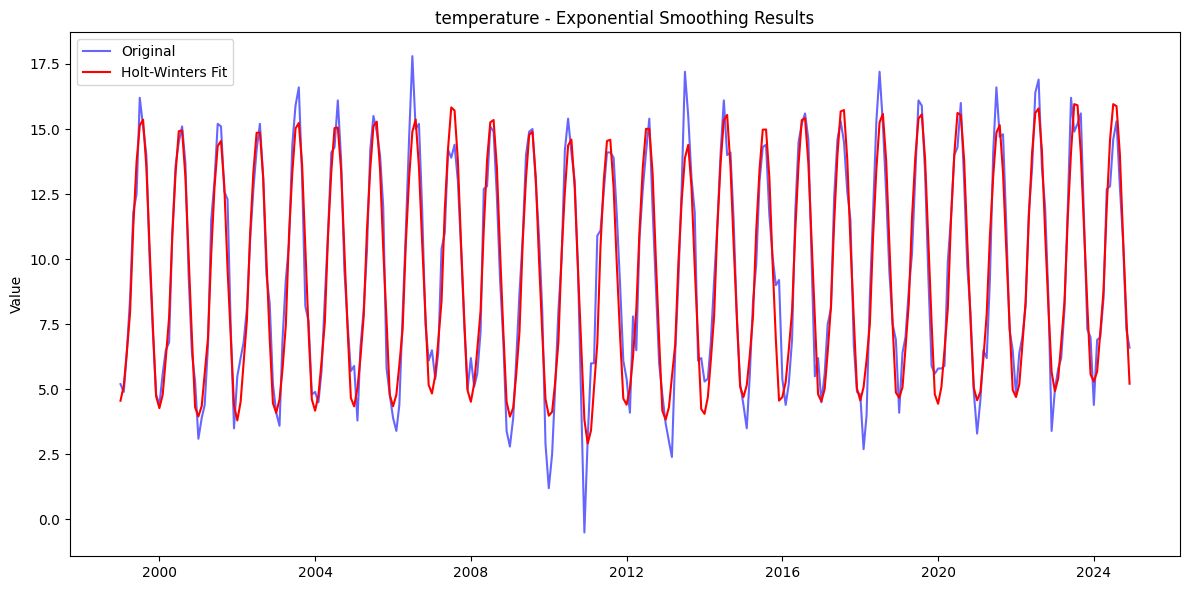


Model Summary for temperature:
                       ExponentialSmoothing Model Results                       
Dep. Variable:                     None   No. Observations:                  312
Model:             ExponentialSmoothing   SSE                            401.826
Optimized:                        False   AIC                            110.941
Trend:                         Additive   BIC                            170.829
Seasonal:                      Additive   AICC                           113.276
Seasonal Periods:                    12   Date:                 Sat, 10 May 2025
Box-Cox:                          False   Time:                         16:48:05
Box-Cox Coeff.:                    None                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.1197205                alpha               

/Users/mada/.virtualenvs/mada-proj/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/mada/.virtualenvs/mada-proj/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/mada/.virtualenvs/mada-proj/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/mada/.virtualenvs/mada-proj/lib/python3.10/site-packages/pandas/util/_decorators.py:213: EstimationWarning: Model has no free parameters to estimate. Set optimized=False to suppress this warning
  return func(*args, **kwargs)


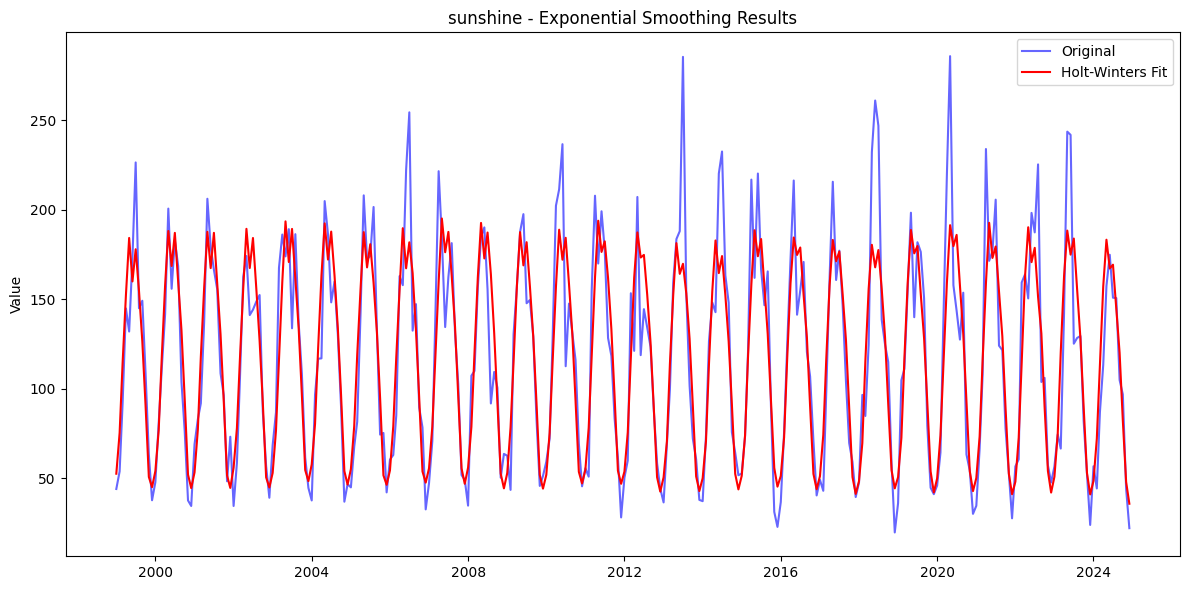


Model Summary for sunshine:
                       ExponentialSmoothing Model Results                       
Dep. Variable:                     None   No. Observations:                  312
Model:             ExponentialSmoothing   SSE                         221712.701
Optimized:                        False   AIC                           2080.634
Trend:                         Additive   BIC                           2140.522
Seasonal:                      Additive   AICC                          2082.968
Seasonal Periods:                    12   Date:                 Sat, 10 May 2025
Box-Cox:                           True   Time:                         16:48:05
Box-Cox Coeff.:                 0.48356                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.0403571                alpha                Fa

/Users/mada/.virtualenvs/mada-proj/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/mada/.virtualenvs/mada-proj/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/mada/.virtualenvs/mada-proj/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


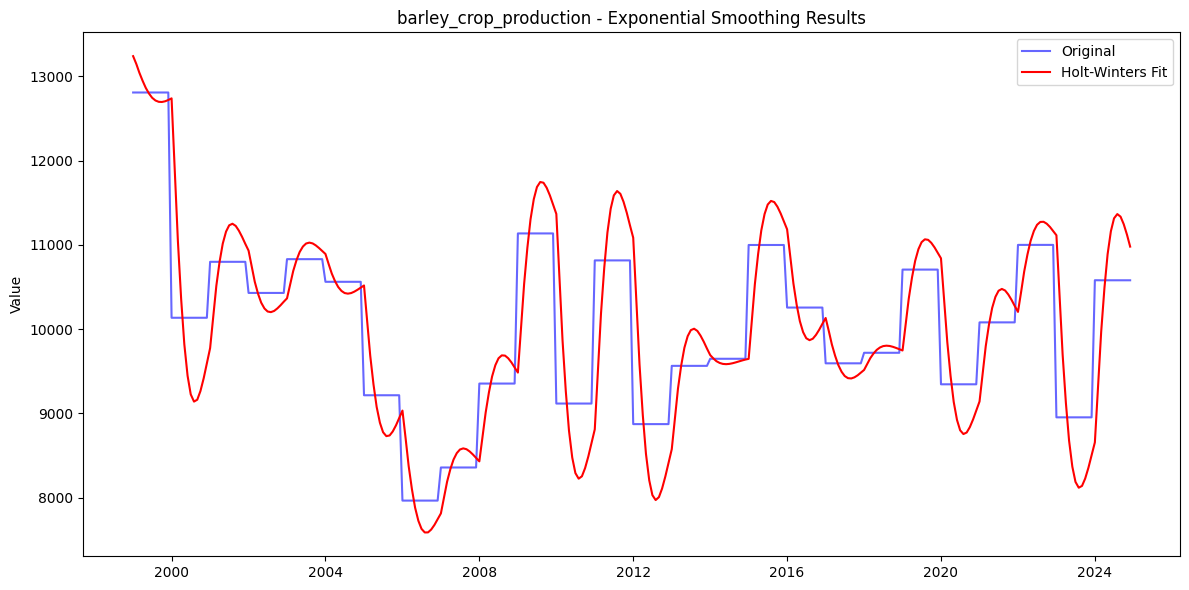


Model Summary for barley_crop_production:
                       ExponentialSmoothing Model Results                       
Dep. Variable:                     None   No. Observations:                  312
Model:             ExponentialSmoothing   SSE                      107202289.041
Optimized:                         True   AIC                           3985.134
Trend:                         Additive   BIC                           4000.106
Seasonal:                          None   AICC                          3985.410
Seasonal Periods:                  None   Date:                 Sat, 10 May 2025
Box-Cox:                          False   Time:                         16:48:05
Box-Cox Coeff.:                    None                                         
                       coeff                 code              optimized      
------------------------------------------------------------------------------
smoothing_level            0.2500000                alpha             

In [29]:

def plot_holtwinters_results(original_series, fitted_values, feature_name):
    """
    Properly aligned plotting function for Holt-Winters results
    """
    fig, ax = plt.subplots(figsize=(12, 6))
    
    # Plot original data with datetime index
    ax.plot(original_series.index, 
            original_series.values, 
            label='Original', 
            color='blue', 
            alpha=0.6)
    
    # Plot fitted values using SAME datetime index
    ax.plot(fitted_values.index, 
            fitted_values.values, 
            label='Holt-Winters Fit', 
            color='red', 
            linewidth=1.5)
    
    ax.set_title(f'{feature_name} - Exponential Smoothing Results')
    ax.set_ylabel('Value')
    ax.legend()
    plt.tight_layout()
    plt.show()

def optimize_holtwinters(series):
    best_aic = float("inf")
    best_params = None
    
    # Test additive vs multiplicative seasonality
    for seasonal in ["add", "mul"]:
        try:
            model = ExponentialSmoothing(
                series,
                trend="add",
                seasonal=seasonal,
                seasonal_periods=12,
                initialization_method="heuristic"  # Better than default
            )
            fit = model.fit()
            if fit.aic < best_aic:
                best_aic = fit.aic
                best_params = {
                    "seasonal": seasonal,
                    "alpha": fit.params["smoothing_level"],
                    "beta": fit.params["smoothing_trend"],
                    "gamma": fit.params["smoothing_seasonal"]
                }
        except Exception as e:
            print(e)
            continue
    
    return best_params

def apply_exponential_smoothing(series, feature_name):
    """Robust Holt-Winters fitting with zero handling and auto-config"""
    
    # 1. Zero/Negative value handling
    min_positive = series[series > 0].min()
    epsilon = min_positive * 0.001  # 0.1% of smallest positive value
    
    # Apply minimal adjustment only where needed
    adjusted_series = series.where(series > 0, epsilon)
    
    # 2. Auto-configure model parameters
    has_zeros = (series <= 0).any()
    use_boxcox = not has_zeros  # Disable Box-Cox if zeros existed originally

    # Find the best smoothing parameters
    best_params = optimize_holtwinters(adjusted_series)
    
    # 3. Model configuration. Note that we treat crop production differently
    if 'crop_production' not in feature:
        model = ExponentialSmoothing(
            adjusted_series,
            trend='add',
            seasonal=best_params["seasonal"],
            seasonal_periods=12,
            use_boxcox=use_boxcox,
            initialization_method='heuristic'
        )
        
        # 4. Fit the model with stronger smoothing parameters (lower values)
        fit = model.fit(smoothing_level=best_params["alpha"],  # Alpha (level smoothing)
                        smoothing_trend=best_params["beta"],  # Beta (trend smoothing)
                        smoothing_seasonal=best_params["gamma"])  # Gamma (seasonal smoothing)
    else:
        model = ExponentialSmoothing(
            adjusted_series,
            trend="add",  # Additive trend
            seasonal=None,  # No seasonality detected due to uniform monthly values
            initialization_method="estimated"
        )
        fit = model.fit(smoothing_level=0.25, smoothing_trend=0.35)
    
    # 5. Plot results
    plot_holtwinters_results(series, fit.fittedvalues, feature_name)
    
    return fit

# Process and plot each feature
fitted_values_dict = {}
for feature, data in final_df.iterrows():
    ts = pd.Series(data.values.astype(float),
                 index=pd.to_datetime(final_df.columns, format='%b_%Y'))
    print(ts)
    feature_resulting_values = ts
    # Apply smoothing to ALL data as per suggestion from Prof Yao.
    result_model = apply_exponential_smoothing(ts, feature)
    feature_resulting_values = result_model.fittedvalues
    # Print model summary
    print(f"\nModel Summary for {feature}:")
    print(result_model.summary())
    # Store fitted values
    fitted_values_dict[feature] = feature_resulting_values
    
smoothed_weather_data = pd.DataFrame(fitted_values_dict)
print(smoothed_weather_data)


# Apply nested cross-validation alongside exponential smoothing

Outer Loop - Fold 0: -->  Train: index=[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49]  >>>  Test:  index=[50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73
 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97
 98 99]
     Inner Loop - Fold 0: --> learning_rate: 0.001, batch_size: 16, epochs: 50 >>> Train: index=[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13]  >>>  Test:  index=[14 15 16 17 18 19 20 21 22 23 24 25]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
     Inner Loop - Fold 1: --> learning_rate: 0.001, batch_size: 16, epochs: 50 >>> Train: index=[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25]  >>>  Test:  index=[26 27 28 29 30 31 32 33 34 35 36 37]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
     Inner Loop - Fold 2: --> learning_rate: 0.001, batch_size: 16, epochs: 50 >>> Train: index=[ 0  1  2  3  4  5  6  7  8  9 

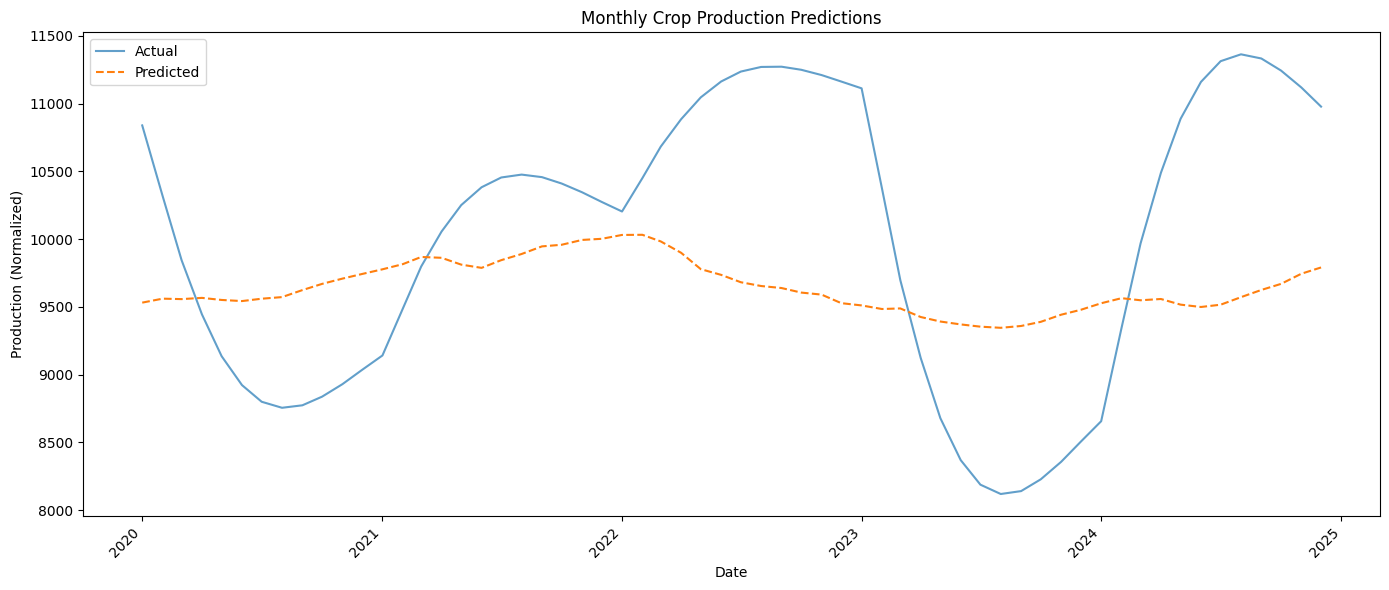

In [30]:
# Define parameters to use through the cross validation
sequence_length = 12 # monthly data repeating in periods of 12 months
# Prepare sequences for LSTM
def create_monthly_sequences(data, n_steps=12):
    X, y = [], []
    for i in range(len(data)-n_steps):
        X.append(data.iloc[i:i+n_steps, :-1].values)  # Climate features
        y.append(data.iloc[i+n_steps, -1])            # Crop production
    return np.array(X), np.array(y)

# Normalize data (excluding datetime index)
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(smoothed_weather_data)

# Create sequences using 12 months of history
X, y = create_monthly_sequences(pd.DataFrame(scaled_data, 
                                           index=smoothed_weather_data.index), 
                              n_steps=sequence_length)

# Define function to build LSTM model
def build_lstm_model(input_shape, learning_rate):
    model = Sequential()
    model.add(Input(shape=input_shape))
    model.add(LSTM(64, activation='tanh'))
    model.add(Dropout(0.3))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1))
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mse')
    return model

# Define the outer and inner splitsNested Cross-Validation with LSTM
outer_cv = TimeSeriesSplit(n_splits=5)
inner_cv = TimeSeriesSplit(n_splits=3)

# Define the Hyperparameter grid for inner loop tuning
param_grid = {
    'learning_rate': [0.001, 0.01],
    'batch_size': [16, 32],
    'epochs': [50, 100]
}

# Implement outer and inner loops of tuning
outer_scores = []
best_params_list = []
all_predictions = []  # Store predictions for all outer folds
all_y_test = []

for i, (train_idx, test_idx) in enumerate(outer_cv.split(X)):
    print(f"Outer Loop - Fold {i}: -->  Train: index={train_idx}  >>>  Test:  index={test_idx}")
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    
    best_score = float('inf')
    best_params = None
    
    for learning_rate in param_grid['learning_rate']:
        for batch_size in param_grid['batch_size']:
            for epochs in param_grid['epochs']:
                inner_scores = []
                
                for j, (inner_train_idx, inner_val_idx) in enumerate(inner_cv.split(X_train)):
                    print(f"     Inner Loop - Fold {j}: --> learning_rate: {learning_rate}, batch_size: {batch_size}, epochs: {epochs} >>> Train: index={inner_train_idx}  >>>  Test:  index={inner_val_idx}")
                    X_inner_train, X_inner_val = X_train[inner_train_idx], X_train[inner_val_idx]
                    y_inner_train, y_inner_val = y_train[inner_train_idx], y_train[inner_val_idx]
                    
                    model = build_lstm_model((X_inner_train.shape[1], X_inner_train.shape[2]), learning_rate)
                    model.fit(X_inner_train, y_inner_train, epochs=epochs, batch_size=batch_size, verbose=0)
                    
                    y_pred = model.predict(X_inner_val)
                    inner_scores.append(mean_squared_error(y_inner_val, y_pred))
                
                avg_inner_score = np.mean(inner_scores)
                if avg_inner_score < best_score:
                    best_score = avg_inner_score
                    best_params = {'learning_rate': learning_rate, 'batch_size': batch_size, 'epochs': epochs}
    
    best_params_list.append(best_params)
    best_model = build_lstm_model((X_train.shape[1], X_train.shape[2]), best_params['learning_rate'])
    best_model.fit(X_train, y_train, epochs=best_params['epochs'], batch_size=best_params['batch_size'], verbose=0)
    
    y_pred = best_model.predict(X_test)
    outer_scores.append(mean_squared_error(y_test, y_pred))
    
    all_predictions.append(y_pred.flatten())  # Store predictions
    all_y_test.append(y_test) #store the y_test values


print(f"Nested CV Mean MSE: {np.mean(outer_scores)}")
print(f"Best parameters for each fold: {best_params_list}")

# Find the best parameters overall (lowest average MSE)
best_fold_index = np.argmin(outer_scores)
best_params = best_params_list[best_fold_index]
best_predictions = all_predictions[best_fold_index]
best_y_test = all_y_test[best_fold_index]

print(f" Best Hyper paarameters (overall): {best_params} with MSE: {outer_scores[best_fold_index]}")

# Retrain the model with the best parameters on the entire training set
split = int(0.8 * len(X))
X_final_train, X_final_test = X[:split], X[split:]
y_final_train, y_final_test = y[:split], y[split:]
final_model = build_lstm_model((X_final_train.shape[1], X_final_train.shape[2]), best_params['learning_rate'])
final_model.fit(X_final_train, y_final_train, epochs=best_params['epochs'], batch_size=best_params['batch_size'], verbose=0) #Retrain using an 80/20 ratio

# Make predictions using the retrained model
final_predictions = final_model.predict(X_final_test)

# Visualization
def inverse_scale_preds(features, predictions):
    dummy = np.zeros((len(predictions), features.shape[1]+1))
    dummy[:, :-1] = features  # Original climate features
    dummy[:, -1:] = predictions
    return scaler.inverse_transform(dummy)[:, -1]

test_preds = inverse_scale_preds(X_final_test[:, -1, :], final_predictions)

# Get actual values
y_actual = inverse_scale_preds(X_final_test[:, -1, :], y_final_test.reshape(y_final_test.shape[0],1))# This is needed because the inverse scaling function needs the arrays to be the same shape

# 7. Visualize results with dates
dates = smoothed_weather_data.index[12+split:]  # Offset by window size + split point

plt.figure(figsize=(14, 6))
plt.plot(dates, y_actual, label='Actual', alpha=0.7)
plt.plot(dates, test_preds, label='Predicted', linestyle='--')
plt.title('Monthly Crop Production Predictions')
plt.xlabel('Date')
plt.ylabel('Production (Normalized)')
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.tight_layout()
plt.show()

# Use the output of the smoothing to feed directly an LSTM model (for comparison with Nested Cross-Validation)

Epoch 1/100


/Users/mada/.virtualenvs/mada-proj/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.1473 - val_loss: 0.0456
Epoch 2/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0476 - val_loss: 0.0418
Epoch 3/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0405 - val_loss: 0.0368
Epoch 4/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0376 - val_loss: 0.0339
Epoch 5/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0316 - val_loss: 0.0350
Epoch 6/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0357 - val_loss: 0.0341
Epoch 7/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0371 - val_loss: 0.0332
Epoch 8/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0405 - val_loss: 0.0345
Epoch 9/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0345 - val_loss: 0.0332
Epoch 10/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0361 - val_loss: 0.0351
Epoch 11/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0377 - val_loss: 0.0340
Epoch 12/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0333 - val_l

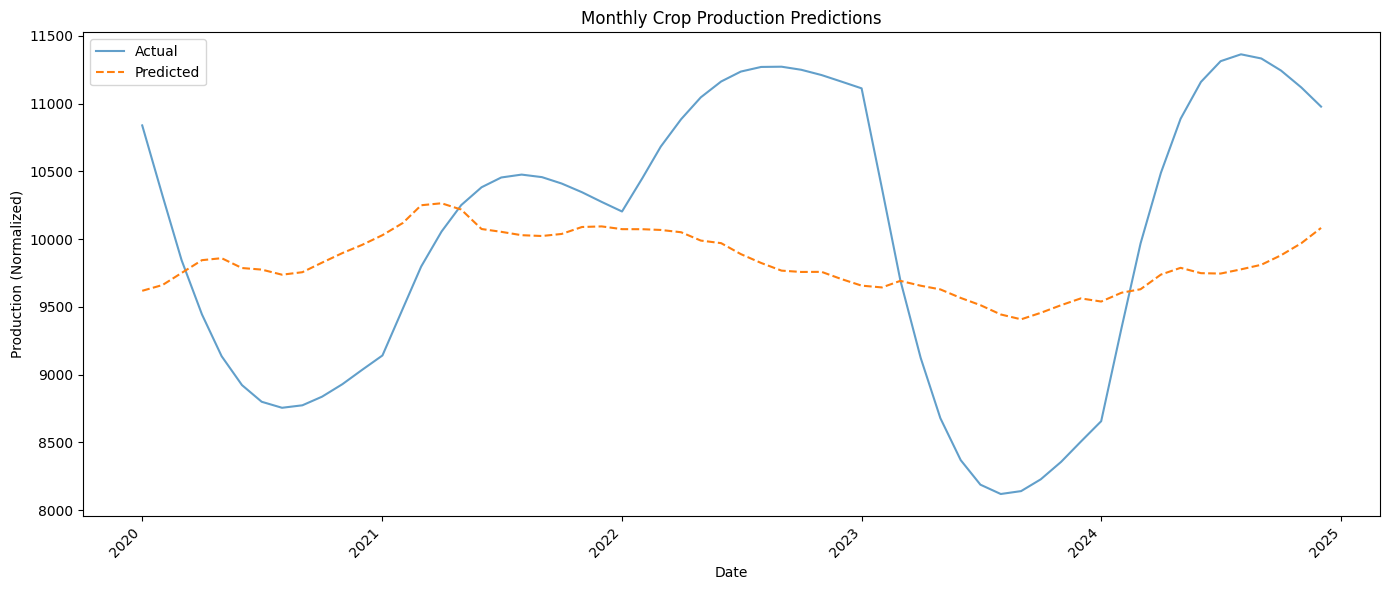

In [31]:
# 2. Prepare sequences for LSTM
def create_monthly_sequences(data, n_steps=12):
    X, y = [], []
    for i in range(len(data)-n_steps):
        X.append(data.iloc[i:i+n_steps, :-1].values)  # Climate features
        y.append(data.iloc[i+n_steps, -1])            # Crop production
    return np.array(X), np.array(y)

# Normalize data (excluding datetime index)
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(smoothed_weather_data)

# Create sequences using 12 months of history
X, y = create_monthly_sequences(pd.DataFrame(scaled_data, 
                                           index=smoothed_weather_data.index), 
                              n_steps=12)

# 3. Split data (maintain temporal order)
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# 4. Build LSTM model
model = Sequential([
    LSTM(64, activation='tanh', 
        input_shape=(X_train.shape[1], X_train.shape[2]),
        return_sequences=False),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')

# 5. Train model
history = model.fit(X_train, y_train,
                  epochs=100,
                  batch_size=24,
                  validation_data=(X_test, y_test),
                  verbose=1)

# 6. Predict and inverse scaling
def inverse_scale_preds(features, predictions):
    dummy = np.zeros((len(predictions), features.shape[1]+1))
    dummy[:, :-1] = features  # Original climate features
    dummy[:, -1:] = predictions
    return scaler.inverse_transform(dummy)[:, -1]

# Make predictions
test_preds = model.predict(X_test)
test_preds = inverse_scale_preds(X_test[:, -1, :], test_preds)

# Get actual values
y_actual = inverse_scale_preds(X_test[:, -1, :], y_test.reshape(y_test.shape[0],1))# This is needed because the inverse scaling function needs the arrays to be the same shape

# 7. Visualize results with dates
dates = smoothed_weather_data.index[12+split:]  # Offset by window size + split point

plt.figure(figsize=(14, 6))
plt.plot(dates, y_actual, label='Actual', alpha=0.7)
plt.plot(dates, test_preds, label='Predicted', linestyle='--')
plt.title('Monthly Crop Production Predictions')
plt.xlabel('Date')
plt.ylabel('Production (Normalized)')
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.tight_layout()
plt.show()

# Group prediction results by year

In [ ]:
# Create a DataFrame for predictions and actual values (the previous cell MUST have been executed previously)
data = pd.DataFrame({
    'Date': dates,
    'Predicted': test_preds,
    'Actual': y_actual
})

# Convert the 'Date' column to datetime format
data['Date'] = pd.to_datetime(data['Date'])

# Roll up to yearly basis by taking the sum for each year
data['Year'] = data['Date'].dt.year

# Roll up to yearly basis by summing only numeric columns
yearly_data = data.groupby('Year')[['Predicted', 'Actual']].sum()

# Plot yearly data
plt.figure(figsize=(12, 6))
plt.plot(yearly_data.index, yearly_data['Predicted'], label='Predicted', marker='o', linestyle='--', color='blue')
plt.plot(yearly_data.index, yearly_data['Actual'], label='Actual', marker='o', linestyle='-', color='orange')

# Add labels, title, and legend
plt.title('Yearly Crop Production Predictions vs Actuals', fontsize=16)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Crop Production (Sum)', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()
